In [86]:
import csv
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pandas_datareader.data as web
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from matplotlib import pyplot
import scipy.stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
from yahoofinancials import YahooFinancials
%matplotlib inline

In [41]:
fpath = 'facebook_data_WSJ_post_sentiment_4dict.tsv'
post_data = pd.read_csv(fpath, sep='\t')
post_data.head()

,ID,PostID,PostDate,Text,Likes,Shares,WNPositive,WNNegative,WNNeutral,WNSentiment,...,HVTokenQnt,HVSentiAvg,LMPositive,LMNegative,LMTokenQnt,LMSentiAvg,Vader_Positive,Vader_Negative,Vader_Neutral,Vader_Compound
0,1,10161085588958128,2021-05-16 19:01:04,This quick beans and rice recipe gets a little...,4,0,0.875,0.375,9.75,0.50,...,15,0.000000,0,0,15,0.000000,0.249,0.000,0.751,0.8074
1,2,10161085508038128,2021-05-16 18:35:05,Jimmy Kimmel wore a white lab coat and head mi...,37,1,0.875,1.625,23.50,-0.75,...,42,0.000000,1,2,42,-0.023810,0.041,0.026,0.933,0.2732
2,3,10161085417148128,2021-05-16 18:00:35,Government efforts to boost economic activity ...,28,3,0.500,1.500,16.00,-1.00,...,28,0.035714,2,2,28,0.000000,0.124,0.046,0.830,0.5574
3,4,10161085362453128,2021-05-16 17:30:18,"As the U.S. real-estate market picks up, incre...",42,4,0.250,0.500,19.25,-0.25,...,29,0.000000,0,2,29,-0.068966,0.040,0.103,0.857,-0.3182
4,5,10161085218303128,2021-05-16 16:30:17,Some retailers are grooming their own data sci...,117,9,0.000,0.000,12.00,0.00,...,20,-0.050000,1,1,20,0.000000,0.058,0.000,0.942,0.2023


In [42]:
post_data['Vader_Average'] = post_data['Vader_Positive'] - post_data['Vader_Negative']

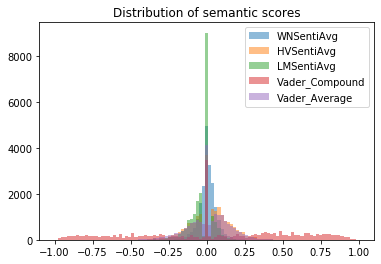

In [43]:
bins = np.linspace(-1, 1, 100)
pyplot.hist(post_data['WNSentiAvg'], bins, alpha=0.5, label='WNSentiAvg')
pyplot.hist(post_data['HVSentiAvg'], bins, alpha=0.5, label='HVSentiAvg')
pyplot.hist(post_data['LMSentiAvg'], bins, alpha=0.5, label='LMSentiAvg')
pyplot.hist(post_data['Vader_Compound'], bins, alpha=0.5, label='Vader_Compound')
pyplot.hist(post_data['Vader_Positive'] - post_data['Vader_Negative'], bins, alpha=0.5, label='Vader_Average')
pyplot.legend(loc='upper right')
pyplot.title('Distribution of semantic scores')
pyplot.show()

Text(0, 0.5, 'Posts')

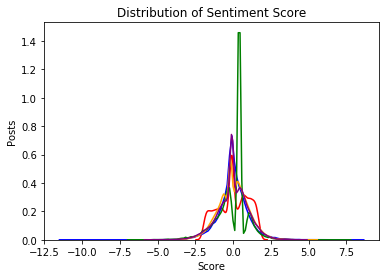

In [44]:


# seaborn histogram
sns.distplot((post_data['Vader_Compound'] - post_data['Vader_Compound'].mean())/post_data['Vader_Compound'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'red',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['WNSentiAvg'] - post_data['WNSentiAvg'].mean())/post_data['WNSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['LMSentiAvg'] - post_data['LMSentiAvg'].mean())/post_data['LMSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'green',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['HVSentiAvg'] - post_data['HVSentiAvg'].mean())/post_data['HVSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'orange',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['Vader_Average'] - post_data['Vader_Average'].mean())/post_data['Vader_Average'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'purple',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Distribution of Sentiment Score')
plt.xlabel('Score')
plt.ylabel('Posts')

In [49]:
post_data[['WNSentiAvg','HVSentiAvg','LMSentiAvg','Vader_Compound','Vader_Average']].describe()

,WNSentiAvg,HVSentiAvg,LMSentiAvg,Vader_Compound,Vader_Average
count,20383.000000,20383.000000,20383.000000,20383.000000,20383.000000
mean,0.007444,0.022795,-0.028422,0.047642,0.011205
std,0.056501,0.130837,0.070412,0.512540,0.137184
min,-0.625000,-0.666667,-0.500000,-0.987000,-0.744000
25%,-0.018750,-0.058824,-0.062500,-0.340000,-0.065000
50%,0.004310,0.000000,0.000000,0.000000,0.000000
75%,0.035714,0.105263,0.000000,0.476700,0.095000
max,0.479167,0.700000,0.500000,0.982100,0.632000


In [50]:
post_data['PostDate'] = pd.to_datetime(post_data['PostDate'], errors='coerce')

post_data['DateMonth'] = post_data['PostDate'].dt.strftime('%Y-%m')
post_data['DateDay'] = post_data['PostDate'].dt.strftime('%Y-%m-%d')

In [51]:
post_data['DateMonth'].head()

0    2021-05
1    2021-05
2    2021-05
3    2021-05
4    2021-05
Name: DateMonth, dtype: object

In [52]:
post_data.columns

Index(['ID', 'PostID', 'PostDate', 'Text', 'Likes', 'Shares', 'WNPositive',
       'WNNegative', 'WNNeutral', 'WNSentiment', 'WNTokenQnt', 'WNSentiAvg',
       'HVPositive', 'HVNegative', 'HVTokenQnt', 'HVSentiAvg', 'LMPositive',
       'LMNegative', 'LMTokenQnt', 'LMSentiAvg', 'Vader_Positive',
       'Vader_Negative', 'Vader_Neutral', 'Vader_Compound', 'Vader_Average',
       'DateMonth', 'DateDay'],
      dtype='object')

In [53]:
Monthly_Data = post_data.groupby('DateMonth').agg({'WNSentiAvg': 'sum'
                                                         ,'WNTokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'HVPositive':'sum'
                                                        ,'HVNegative':'sum'
                                                        ,'HVTokenQnt':'sum'
                                                        ,'LMPositive':'sum'
                                                        ,'LMNegative':'sum'
                                                        ,'LMTokenQnt':'sum'
                                                       })

In [54]:
DailyData = post_data.groupby('DateDay').agg({'WNSentiAvg': 'sum'
                                                        ,'WNTokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'HVPositive':'sum'
                                                        ,'HVNegative':'sum'
                                                        ,'HVTokenQnt':'sum'
                                                        ,'LMPositive':'sum'
                                                        ,'LMNegative':'sum'
                                                        ,'LMTokenQnt':'sum'
                                                        })

In [55]:
DailyData['WNSentiment'] =  DailyData['WNSentiAvg']/ DailyData['WNTokenQnt']
DailyData['HVSentiment'] = (DailyData['HVPositive'] - DailyData['HVNegative'])/DailyData['HVTokenQnt']
DailyData['LMSentiment'] = (DailyData['LMPositive'] - DailyData['LMNegative'])/DailyData['LMTokenQnt']

Monthly_Data['WNSentiment'] =  Monthly_Data['WNSentiAvg']/ Monthly_Data['WNTokenQnt']
Monthly_Data['HVSentiment'] = (Monthly_Data['HVPositive'] - Monthly_Data['HVNegative'])/Monthly_Data['HVTokenQnt']
Monthly_Data['LMSentiment'] = (Monthly_Data['LMPositive'] - Monthly_Data['LMNegative'])/Monthly_Data['LMTokenQnt']



In [56]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['WNSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -16.9450
p-value                           0.0000
#Lags Used                        7.0000
Number of Observations Used    2896.0000
Critical Value (1%)              -3.4326
Critical Value (5%)              -2.8625
Critical Value (10%)             -2.5673
dtype: float64


In [57]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['HVSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -8.2126
p-value                           0.0000
#Lags Used                       21.0000
Number of Observations Used    2882.0000
Critical Value (1%)              -3.4326
Critical Value (5%)              -2.8625
Critical Value (10%)             -2.5673
dtype: float64


In [58]:
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['LMSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value


Test Statistic                   -8.2126
p-value                           0.0000
#Lags Used                       21.0000
Number of Observations Used    2882.0000
Critical Value (1%)              -3.4326
Critical Value (5%)              -2.8625
Critical Value (10%)             -2.5673
dtype: float64
Results of Dickey-Fuller Test:


In [59]:
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['Vader_Compound'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value


Test Statistic                   -6.9893
p-value                           0.0000
#Lags Used                       21.0000
Number of Observations Used    2882.0000
Critical Value (1%)              -3.4326
Critical Value (5%)              -2.8625
Critical Value (10%)             -2.5673
dtype: float64
Results of Dickey-Fuller Test:


In [60]:
DailyData.head()

,WNSentiAvg,WNTokenQnt,Vader_Compound,Vader_Average,HVPositive,HVNegative,HVTokenQnt,LMPositive,LMNegative,LMTokenQnt,WNSentiment,HVSentiment,LMSentiment
DateDay,,,,,,,,,,,,,
2009-01-15,0.025000,2,0.34540,0.036000,5,1,42,0,0,42,0.012500,0.095238,0.000000
2009-01-16,0.335227,4,0.24755,0.185750,4,0,46,0,1,46,0.083807,0.086957,-0.021739
2009-01-18,0.000000,1,0.00000,0.000000,1,1,19,0,1,19,0.000000,0.000000,-0.052632
2009-01-20,0.026961,3,0.31480,0.088333,11,2,52,1,2,52,0.008987,0.173077,-0.019231
2009-01-21,0.070455,3,0.30860,0.042667,14,5,89,2,1,89,0.023485,0.101124,0.011236


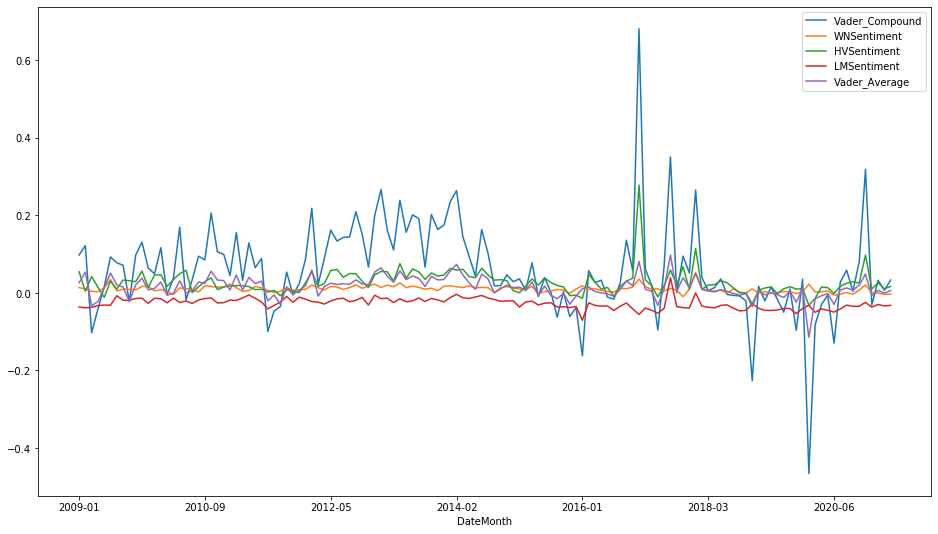

In [61]:
Monthly_Data[['Vader_Compound','WNSentiment','HVSentiment','LMSentiment','Vader_Average']].plot(legend=True, figsize=(16,9))

## Download S&P from Yahoo

In [62]:
SnP_daily = web.get_data_yahoo('^GSPC','10/01/2010','05/01/2021',interval='d')
SnP_monthly = web.get_data_yahoo('^GSPC','10/01/2010','05/01/2021',interval='m')

In [93]:
yahoo_financials = YahooFinancials(['^GSPC']).get_historical_price_data('2010-10-01','2021-05-31','daily')
SnP_daily =pd.DataFrame(yahoo_financials["^GSPC"]["prices"])
SnP_daily.index = SnP_daily['formatted_date']
SnP_daily['LogReturn'] = np.log(SnP_daily['adjclose']/SnP_daily['adjclose'].shift(1))

In [63]:
SnP_daily['LogReturn'] = np.log(SnP_daily['Adj Close']/SnP_daily['Adj Close'].shift(1))

In [64]:
SnP_monthly.index = SnP_monthly.index.strftime('%Y-%m')

In [65]:
SnP_monthly['LogReturn'] = np.log(SnP_monthly['Adj Close']/SnP_monthly['Adj Close'].shift(1))

## Granger test

In [95]:
Granger_data_daily = pd.merge(SnP_daily,DailyData, how= 'inner', left_index=True, right_index=True)

In [76]:
def grangerTest(exog, endog):
    MAX_LAG = 30
    ARaic = AR(exog.tolist()).fit(maxlag=MAX_LAG, ic="aic")
    ARbic = AR(exog.tolist()).fit(maxlag=MAX_LAG, ic="bic")
    # select the fewer number of parameters between both criteria.
    numExog = len(ARaic.params) if len(ARaic.params) < len(ARbic.params) else len(ARbic.params)

    print ("Optimal number of lags for exog data is " + str(numExog))

    ARaic = AR(endog.tolist()).fit(maxlag=MAX_LAG, ic="aic")
    ARbic = AR(endog.tolist()).fit(maxlag=MAX_LAG, ic="bic")
    # select the fewer number of parameters between both criteria.
    numEndog = len(ARaic.params) if len(ARaic.params) < len(ARbic.params) else len(ARbic.params)

    print ("Optimal number of lags for endog data is " + str(numEndog))

    # now that I know the optimal number of parameters, I can call the
    # granger causality function of statsmodels.
    data = pd.concat([endog, exog], axis=1)
    print ("\nGranger causality results of indep onto dep")
    results = grangercausalitytests(data, maxlag=numEndog)

    data = pd.concat([exog, endog], axis=1)
    print ("\nGranger causality results of dep onto indep")
    results = grangercausalitytests(data, maxlag=numExog)
    regr = results[2][1]
    print (regr[0].params)
    print (regr[1].params)
    print (regr[1].pvalues)

In [67]:
Granger_data_monthly = pd.merge(SnP_monthly,Monthly_Data, how= 'inner', left_index=True, right_index=True)

In [68]:
#Granger_data['SS_LogReturn'] = np.log((Granger_data['SentimentScoreAdj']+1)/(Granger_data['SentimentScoreAdj']+1).shift(1))

In [69]:
Granger_data_monthly

,High,Low,Open,Close,Volume,Adj Close,LogReturn,WNSentiAvg,WNTokenQnt,Vader_Compound,Vader_Average,HVPositive,HVNegative,HVTokenQnt,LMPositive,LMNegative,LMTokenQnt,WNSentiment,HVSentiment,LMSentiment
2010-10,1196.140015,1131.869995,1143.489990,1183.260010,89536270000,1183.260010,NaN,1.341688,81,0.205695,0.056000,166,98,1758,29,52,1758,0.016564,0.038680,-0.013083
2010-11,1227.079956,1173.000000,1185.709961,1180.550049,87151070000,1180.550049,-0.002293,1.302210,91,0.105324,0.033143,156,139,2004,23,75,2004,0.014310,0.008483,-0.025948
2010-12,1262.599976,1186.599976,1186.599976,1257.640015,80984530000,1257.640015,0.063256,0.700580,45,0.099407,0.031644,97,82,995,9,34,995,0.015568,0.015075,-0.025126
2011-01,1302.670044,1257.619995,1257.619995,1286.119995,92164940000,1286.119995,0.022393,1.803934,79,0.044758,0.007443,118,90,1564,21,50,1564,0.022835,0.017903,-0.018542
2011-02,1344.069946,1289.140015,1289.140015,1327.219971,59223660000,1327.219971,0.031457,1.702714,124,0.155724,0.046169,215,166,2580,23,73,2580,0.013732,0.018992,-0.019380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01,3870.899902,3662.709961,3764.610107,3714.239990,105548790000,3714.239990,-0.011199,0.041233,2,0.318450,0.048500,7,3,41,1,2,41,0.020616,0.097561,-0.024390
2021-02,3950.429932,3725.620117,3731.169922,3811.149902,98596960000,3811.149902,0.025757,0.173191,308,-0.031419,-0.006912,842,775,6777,113,361,6777,0.000562,0.009886,-0.036594
2021-03,3994.409912,3723.340088,3842.510010,3972.889893,120863560000,3972.889893,0.041563,0.011521,519,0.032541,0.006784,1578,1279,11618,239,585,11618,0.000022,0.025736,-0.029781
2021-04,4218.779785,3992.780029,3992.780029,4181.169922,82869290000,4181.169922,0.051097,-2.336197,581,0.006683,-0.000909,1599,1466,12425,232,651,12425,-0.004021,0.010704,-0.033722


In [96]:
Vars = ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"]
for Var in Vars:
    print("\n" + Var + "\n")
    grangerTest(Granger_data_daily[Var][1:], Granger_data_daily['LogReturn'][1:])


Vader_Compound

Optimal number of lags for exog data is 5
Optimal number of lags for endog data is 3

Granger causality results of indep onto dep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7914  , p=0.0517  , df_denom=1784, df_num=1
ssr based chi2 test:   chi2=3.7977  , p=0.0513  , df=1
likelihood ratio test: chi2=3.7937  , p=0.0514  , df=1
parameter F test:         F=3.7914  , p=0.0517  , df_denom=1784, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7392  , p=0.1760  , df_denom=1781, df_num=2
ssr based chi2 test:   chi2=3.4883  , p=0.1748  , df=2
likelihood ratio test: chi2=3.4849  , p=0.1751  , df=2
parameter F test:         F=1.7392  , p=0.1760  , df_denom=1781, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9826  , p=0.1146  , df_denom=1778, df_num=3
ssr based chi2 test:   chi2=5.9713  , p=0.1130  , df=3
likelihood ratio test: chi2=5.9613  , p=0.1135  , df=3
parameter F tes

Optimal number of lags for exog data is 12
Optimal number of lags for endog data is 3

Granger causality results of indep onto dep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0123  , p=0.0453  , df_denom=1784, df_num=1
ssr based chi2 test:   chi2=4.0191  , p=0.0450  , df=1
likelihood ratio test: chi2=4.0146  , p=0.0451  , df=1
parameter F test:         F=4.0123  , p=0.0453  , df_denom=1784, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5597  , p=0.0776  , df_denom=1781, df_num=2
ssr based chi2 test:   chi2=5.1338  , p=0.0768  , df=2
likelihood ratio test: chi2=5.1264  , p=0.0771  , df=2
parameter F test:         F=2.5597  , p=0.0776  , df_denom=1781, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4217  , p=0.0643  , df_denom=1778, df_num=3
ssr based chi2 test:   chi2=7.2938  , p=0.0631  , df=3
likelihood ratio test: chi2=7.2789  , p=0.0635  , df=3
parameter F test:         F=2.4

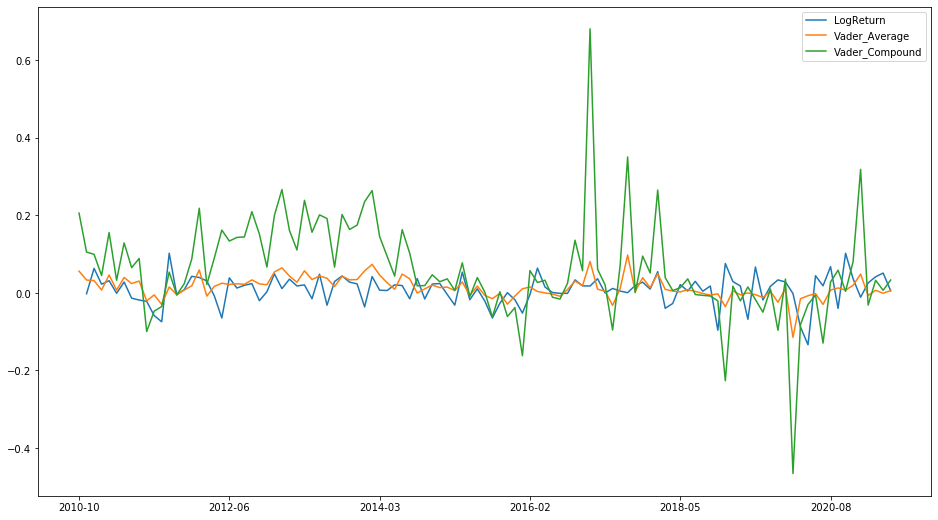

In [33]:
Granger_data_monthly[['LogReturn','Vader_Average','Vader_Compound']].plot(legend=True, figsize=(16,9))

In [80]:
corr = Granger_data_daily[["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment","LogReturn"]].corr()
corr.style.background_gradient(cmap='coolwarm')

,Vader_Compound,Vader_Average,WNSentiment,HVSentiment,LMSentiment,LogReturn
Vader_Compound,1.000000,0.904405,0.383265,0.530518,0.502014,0.024251
Vader_Average,0.904405,1.000000,0.412698,0.522368,0.487853,0.023152
WNSentiment,0.383265,0.412698,1.000000,0.280187,0.230349,0.014645
HVSentiment,0.530518,0.522368,0.280187,1.000000,0.469971,0.016671
LMSentiment,0.502014,0.487853,0.230349,0.469971,1.000000,0.001455
LogReturn,0.024251,0.023152,0.014645,0.016671,0.001455,1.000000


In [82]:
pvals = [] 
for col in ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"]:
    pvals.append(scipy.stats.linregress(Granger_data_daily['LogReturn'][1:], Granger_data_daily[col][1:].dropna())[3])
corr_signif = pd.DataFrame(pvals,columns = ['p-value']
                           ,index = ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"])
#print(corr_signif.to_latex())
print(corr_signif)

                 p-value
Vader_Compound  0.306768
Vader_Average   0.329231
WNSentiment     0.537146
HVSentiment     0.482359
LMSentiment     0.951121


In [38]:
pvals_mnt = [] 
for col in ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average']:
    pvals_mnt.append(scipy.stats.linregress(Granger_data_monthly['LogReturn'][1:], Granger_data_monthly[col][1:].dropna())[3])
corr_signif_mnt = pd.DataFrame(pvals_mnt,columns = ['p-value']
                           ,index = ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average'])
corr_signif_mnt

,p-value
Vader_Compound,0.084306
Flair_Score,0.977764
SentimentScoreAdj,0.311650
Vader_Average,0.047369


In [84]:
DailyData.to_csv('WSJ_variables.tsv', sep='\t')

In [ ]:
all_descriptors.to_csv('Google_Trends_variables_all.tsv', sep='\t')